In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,cross_val_score,cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.metrics import mean_squared_error as mse, f1_score, confusion_matrix,classification_report
from sklearn.metrics import fbeta_score,make_scorer
import scipy
from scipy.stats import chi2_contingency


from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import imblearn
from imblearn.metrics import geometric_mean_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost
import warnings

In [174]:
warnings.filterwarnings("ignore")

In [198]:
data=pd.read_csv("customer_booking_after_feature_selection.csv")
data.drop(columns=["Unnamed: 0"],inplace=True)

## 1- Train Model with:
* flight_duration,
* wants_extra_baggage
* booking_origin
* route
* length_of_stay
* wants_preferred_seat
* num_passengers

In [199]:
new_data=pd.get_dummies(data)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31908 entries, 0 to 31907
Columns: 875 entries, flight_duration to route_URTXIY
dtypes: float64(1), int64(5), uint8(869)
memory usage: 27.9 MB


In [200]:
Y=new_data["booking_complete"]
X=new_data.drop(columns=["booking_complete"])


for col in X.columns:
    if len(X[col].unique())==2:
        if (1 in X[col].unique()) and (0 in X[col].unique()):
            X[col]=X[col].astype("int")

In [201]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=15,stratify=Y)
print("x_train: ",x_train.shape,"y_train: ",y_train.shape,
      "x_test: ",x_test.shape,"y_test: ",y_test.shape)

x_train:  (22335, 874) y_train:  (22335,) x_test:  (9573, 874) y_test:  (9573,)


In [202]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy="minority")
smote
x_sm,y_sm=smote.fit_resample(x_train,y_train)
y_sm.value_counts()
x_sm.shape


x_sm.drop_duplicates(inplace=True)

In [203]:
sm_df=pd.concat([x_sm,pd.DataFrame(y_sm)],axis=1)
sm_df.drop_duplicates(inplace=True)
sm_df=sm_df.dropna()

In [204]:
x_sm_train=sm_df.drop(columns=["booking_complete"])
y_sm_train=sm_df["booking_complete"]


In [205]:
x_sm_train.head()

,flight_duration,wants_extra_baggage,length_of_stay,wants_preferred_seat,num_passengers,booking_origin_(not set),booking_origin_Algeria,booking_origin_Argentina,booking_origin_Australia,booking_origin_Austria,...,route_TGGTPE,route_TGGXIY,route_TPETRZ,route_TPETWU,route_TPEURT,route_TPEVTE,route_TRZWUH,route_TWUWUH,route_TWUXIY,route_URTXIY
0,6.62,0.0,28.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.00,1.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.58,1.0,27.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.83,0.0,22.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.62,0.0,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [190]:
rnf=RandomForestClassifier()


In [191]:
def cross_validation(model,metric,x_train,y_train,x_test,y_test):
    # evaluate a model with repeated stratified k fold cv
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
    
    scores = cross_validate(model, x_train,y_train,
                            scoring=metric, cv=cv, n_jobs=-1,return_estimator=True)
    print("score: ",scores["test_score"].mean()*100)
    
    predictions=scores["estimator"][0].predict(x_test)
   
    matrix=confusion_matrix(predictions,y_test)
    print(matrix)
    print(classification_report(predictions,y_test))
    sns.heatmap(matrix,annot=True)
    plt.xlabel("Predictions")
    plt.ylabel("True classes ")

score:  73.24087500656462
[[6484  926]
 [1564  599]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      7410
           1       0.39      0.28      0.32      2163

    accuracy                           0.74      9573
   macro avg       0.60      0.58      0.58      9573
weighted avg       0.71      0.74      0.72      9573



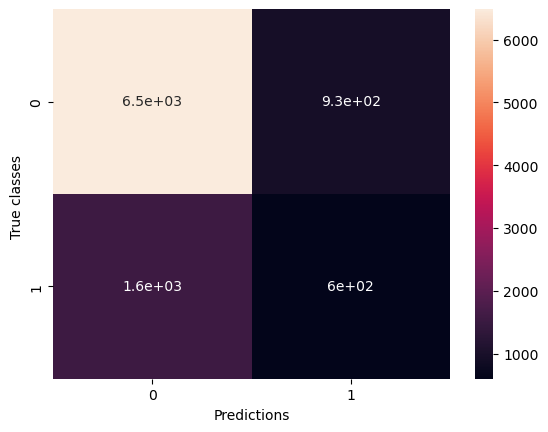

In [30]:
cross_validation(rnf,"accuracy")

In [70]:
beta=2
f2_scorer = make_scorer(fbeta_score, beta=beta)
g_mean_scorer = make_scorer(geometric_mean_score)

score:  69.68352208237192
[[6502  913]
 [1546  612]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      7415
           1       0.40      0.28      0.33      2158

    accuracy                           0.74      9573
   macro avg       0.60      0.58      0.59      9573
weighted avg       0.72      0.74      0.73      9573



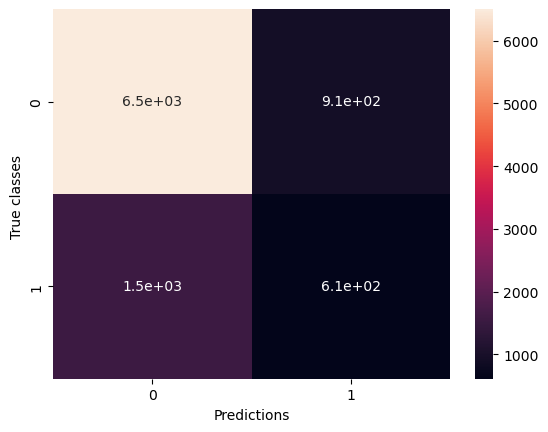

In [32]:
cross_validation(rnf,f2_scorer)

score:  72.94465939565214
[[6540  916]
 [1508  609]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      7456
           1       0.40      0.29      0.33      2117

    accuracy                           0.75      9573
   macro avg       0.61      0.58      0.59      9573
weighted avg       0.72      0.75      0.73      9573



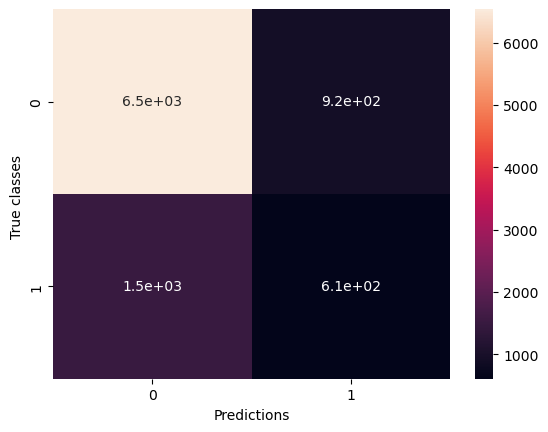

In [33]:
cross_validation(rnf,g_mean_scorer)

score:  81.4204186530294
[[6483  912]
 [1565  613]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      7395
           1       0.40      0.28      0.33      2178

    accuracy                           0.74      9573
   macro avg       0.60      0.58      0.59      9573
weighted avg       0.71      0.74      0.72      9573



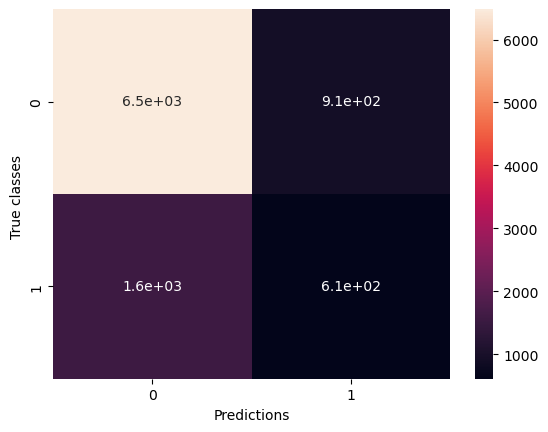

In [34]:
cross_validation(rnf,"roc_auc")

score:  73.02616135139736
[[6555  935]
 [1493  590]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      7490
           1       0.39      0.28      0.33      2083

    accuracy                           0.75      9573
   macro avg       0.60      0.58      0.59      9573
weighted avg       0.72      0.75      0.73      9573



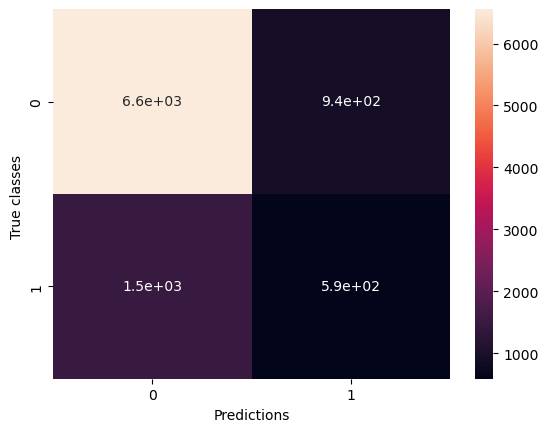

In [35]:
cross_validation(rnf,"balanced_accuracy")

score:  66.7105351039534
[[6516  906]
 [1532  619]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      7422
           1       0.41      0.29      0.34      2151

    accuracy                           0.75      9573
   macro avg       0.61      0.58      0.59      9573
weighted avg       0.72      0.75      0.73      9573



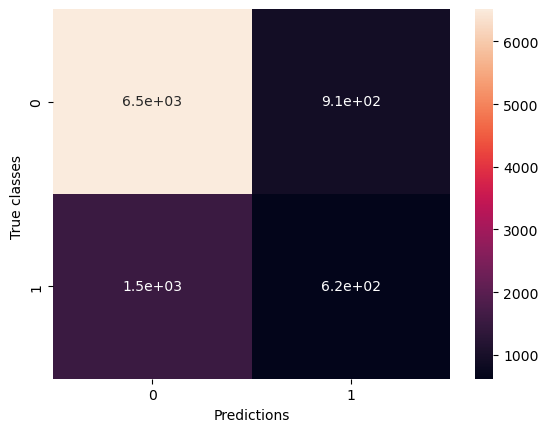

In [36]:
cross_validation(rnf,"f1")

## 2- Train Model with the best features after OneHotEncoding:

In [139]:
best_26_features=['flight_duration', 'wants_extra_baggage', 'length_of_stay',
                  'wants_preferred_seat','num_passengers',
                 'booking_origin_Malaysia', 'booking_origin_Australia', 'route_PENTPE',
                  'route_ICNPEN', 'booking_origin_Indonesia', 'route_BKIICN', 'route_JHBKTM',
                  'route_ICNSYD', 'route_KIXPEN', 'booking_origin_Singapore', 'route_AKLKUL',
                  'booking_origin_South Korea', 'booking_origin_Thailand', 'route_JHBTPE', 
                  'route_MELTPE', 'sales_channel_Mobile', 'route_ICNJHB', 'route_ICNLGK', 
                  'route_ICNKCH', 'route_LGKTPE']

In [140]:
data=pd.read_csv("Custmer Booking clean data.csv")
new_data=pd.get_dummies(data)
Y=new_data["booking_complete"]
X=new_data[best_26_features]


for col in X.columns:
    if len(X[col].unique())==2:
        if (1 in X[col].unique()) and (0 in X[col].unique()):
            X[col]=X[col].astype("int")
            
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=15,stratify=Y)
print("x_train: ",x_train.shape,"y_train: ",y_train.shape,
      "x_test: ",x_test.shape,"y_test: ",y_test.shape)

x_train:  (22335, 25) y_train:  (22335,) x_test:  (9573, 25) y_test:  (9573,)


In [141]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy="minority")
smote
x_sm,y_sm=smote.fit_resample(x_train,y_train)
y_sm.value_counts()
x_sm.shape

sm_df=pd.concat([x_sm,pd.DataFrame(y_sm)],axis=1)
sm_df.drop_duplicates(inplace=True)



In [142]:
x_sm_train=sm_df.drop(columns=["booking_complete"])
y_sm_train=sm_df["booking_complete"]
print(x_sm_train.shape,y_sm_train.shape)


(14364, 25) (14364,)


score:  69.11655517497832
[[5772  884]
 [2276  641]]
              precision    recall  f1-score   support

           0       0.72      0.87      0.79      6656
           1       0.42      0.22      0.29      2917

    accuracy                           0.67      9573
   macro avg       0.57      0.54      0.54      9573
weighted avg       0.63      0.67      0.63      9573



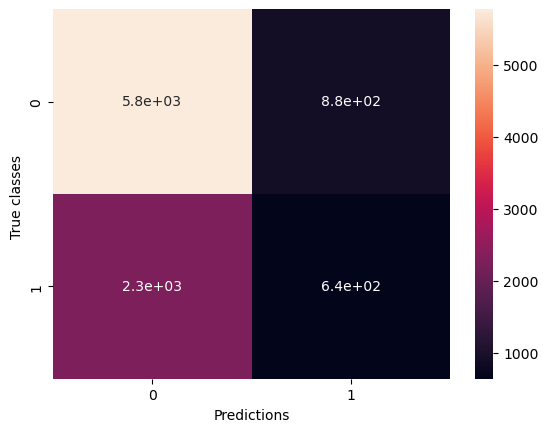

In [114]:
cross_validation(rnf,"accuracy",x_sm_train,y_sm_train,x_test,y_test)

score:  71.64664753347888
[[5672  897]
 [2376  628]]
              precision    recall  f1-score   support

           0       0.70      0.86      0.78      6569
           1       0.41      0.21      0.28      3004

    accuracy                           0.66      9573
   macro avg       0.56      0.54      0.53      9573
weighted avg       0.61      0.66      0.62      9573



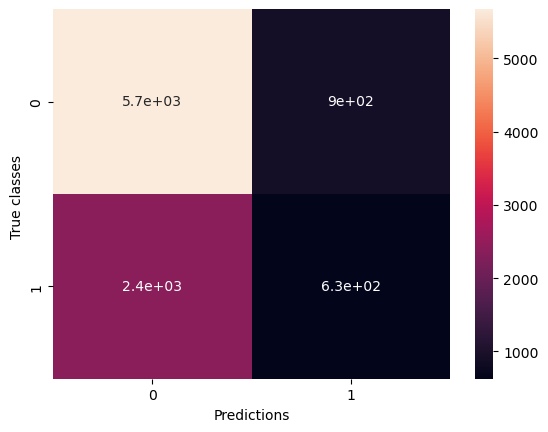

In [115]:
cross_validation(rnf,f2_scorer,x_sm_train,y_sm_train,x_test,y_test)

score:  68.87573573510764
[[5850  933]
 [2198  592]]
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      6783
           1       0.39      0.21      0.27      2790

    accuracy                           0.67      9573
   macro avg       0.56      0.54      0.53      9573
weighted avg       0.63      0.67      0.64      9573



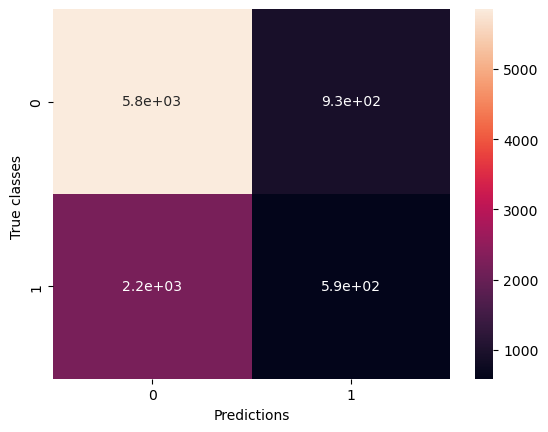

In [116]:
cross_validation(rnf,g_mean_scorer,x_sm_train,y_sm_train,x_test,y_test)

score:  78.89855756733009
[[5876  903]
 [2172  622]]
              precision    recall  f1-score   support

           0       0.73      0.87      0.79      6779
           1       0.41      0.22      0.29      2794

    accuracy                           0.68      9573
   macro avg       0.57      0.54      0.54      9573
weighted avg       0.64      0.68      0.65      9573



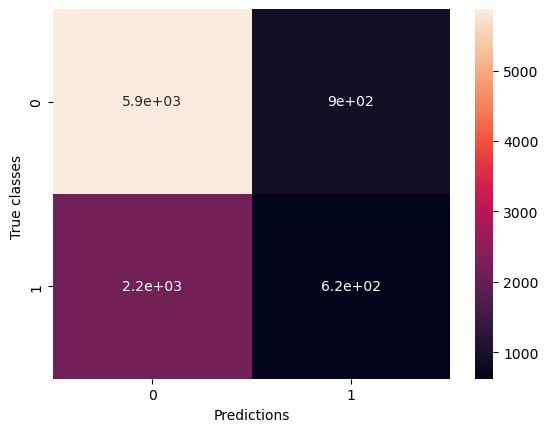

In [117]:
cross_validation(rnf,"roc_auc",x_sm_train,y_sm_train,x_test,y_test)

score:  71.42026949224461
[[5774  931]
 [2274  594]]
              precision    recall  f1-score   support

           0       0.72      0.86      0.78      6705
           1       0.39      0.21      0.27      2868

    accuracy                           0.67      9573
   macro avg       0.55      0.53      0.53      9573
weighted avg       0.62      0.67      0.63      9573



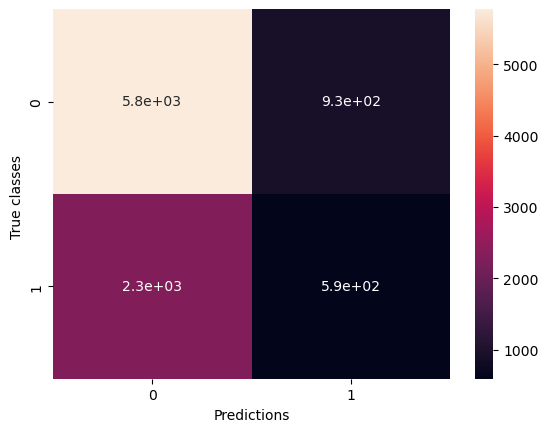

In [118]:
cross_validation(rnf,"f1",x_sm_train,y_sm_train,x_test,y_test)

score:  68.84854954900811
[[5727  906]
 [2321  619]]
              precision    recall  f1-score   support

           0       0.71      0.86      0.78      6633
           1       0.41      0.21      0.28      2940

    accuracy                           0.66      9573
   macro avg       0.56      0.54      0.53      9573
weighted avg       0.62      0.66      0.63      9573



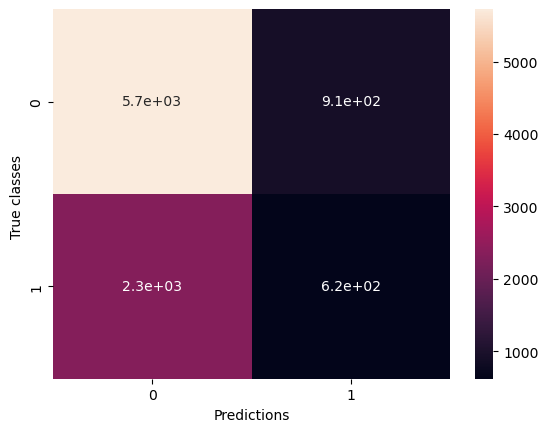

In [119]:
cross_validation(rnf,"balanced_accuracy",x_sm_train,y_sm_train,x_test,y_test)

## 3- Use PCA 

In [121]:
X

,flight_duration,wants_extra_baggage,length_of_stay,wants_preferred_seat,num_passengers,booking_origin_Malaysia,booking_origin_Australia,route_PENTPE,route_ICNPEN,booking_origin_Indonesia,...,route_AKLKUL,booking_origin_South Korea,booking_origin_Thailand,route_JHBTPE,route_MELTPE,sales_channel_Mobile,route_ICNJHB,route_ICNLGK,route_ICNKCH,route_LGKTPE
0,5.52,1,19,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.52,0,20,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5.52,1,22,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5.52,1,48,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5.52,0,22,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31903,5.62,1,6,0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31904,5.62,0,6,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31905,5.62,0,6,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31906,5.62,1,6,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
Y=new_data["booking_complete"]
X=new_data.drop(columns=["booking_complete"])


for col in X.columns:
    if len(X[col].unique())==2:
        if (1 in X[col].unique()) and (0 in X[col].unique()):
            X[col]=X[col].astype("int")

In [131]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=15,stratify=Y)
print("x_train: ",x_train.shape,"y_train: ",y_train.shape,
      "x_test: ",x_test.shape,"y_test: ",y_test.shape)

x_train:  (22335, 884) y_train:  (22335,) x_test:  (9573, 884) y_test:  (9573,)


In [132]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy="all")
smote
x_sm,y_sm=smote.fit_resample(x_train,y_train)
y_sm.value_counts()
x_sm.shape

sm_df=pd.concat([x_sm,pd.DataFrame(y_sm)],axis=1)
sm_df.drop_duplicates(inplace=True)

In [133]:
x_sm_train=sm_df.drop(columns=["booking_complete"])
y_sm_train=sm_df["booking_complete"]

In [134]:
sm_df.shape


(37215, 885)

In [135]:
from sklearn.decomposition import PCA

nf = 100
train_pca = PCA(n_components=nf)
test_pca=PCA(n_components=nf)
# X is the matrix transposed (n samples on the rows, m features on the columns)
train_pca.fit(x_sm_train)
test_pca.fit(x_test)

new_x_sm_train = train_pca.transform(x_sm_train)
new_x_test = test_pca.transform(x_test)



In [56]:
print(new_x_sm_train.shape,new_x_test.shape)
print(y_sm_train.shape,y_test.shape)

(37554, 100) (9573, 100)
(37554,) (9573,)


In [96]:
new_x_sm_train[0].mean()


0.1635789225559069

In [64]:
y_test[y_test==1].sum()

1525

score:  85.84704667826638
[[8039 1524]
 [   9    1]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      9563
           1       0.00      0.10      0.00        10

    accuracy                           0.84      9573
   macro avg       0.50      0.47      0.46      9573
weighted avg       1.00      0.84      0.91      9573



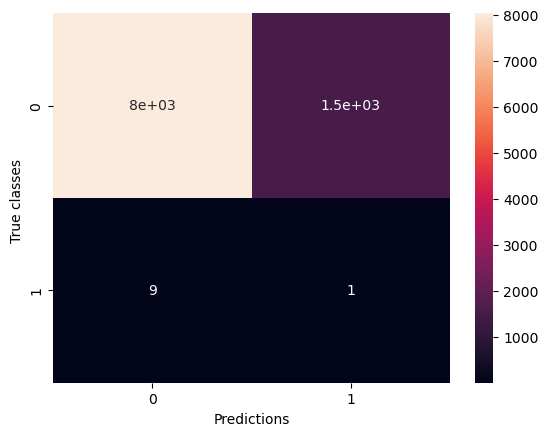

In [59]:
cross_validation(rnf,"accuracy",new_x_sm_train,y_sm_train,new_x_test,y_test)

score:  87.49965086499827
[[8029 1524]
 [  19    1]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      9553
           1       0.00      0.05      0.00        20

    accuracy                           0.84      9573
   macro avg       0.50      0.45      0.46      9573
weighted avg       1.00      0.84      0.91      9573



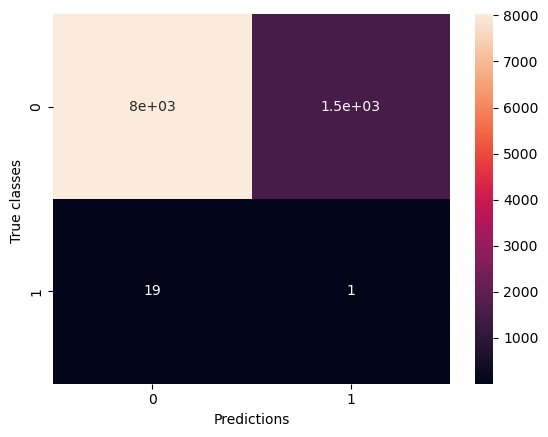

In [71]:
cross_validation(rnf,f2_scorer,new_x_sm_train,y_sm_train,new_x_test,y_test)

score:  85.80966622958357
[[8034 1521]
 [  14    4]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      9555
           1       0.00      0.22      0.01        18

    accuracy                           0.84      9573
   macro avg       0.50      0.53      0.46      9573
weighted avg       1.00      0.84      0.91      9573



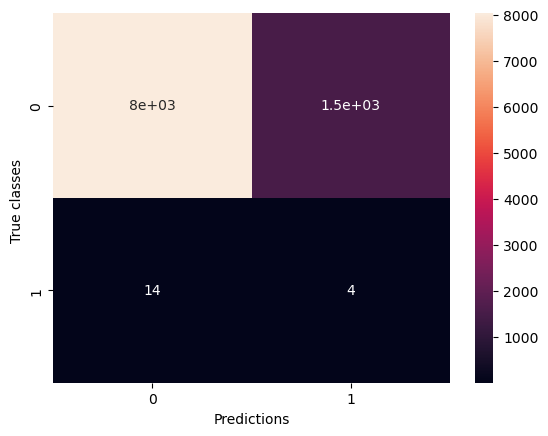

In [72]:
cross_validation(rnf,g_mean_scorer,new_x_sm_train,y_sm_train,new_x_test,y_test)

score:  86.1147312589868
[[7995 1520]
 [  53    5]]
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      9515
           1       0.00      0.09      0.01        58

    accuracy                           0.84      9573
   macro avg       0.50      0.46      0.46      9573
weighted avg       0.99      0.84      0.90      9573



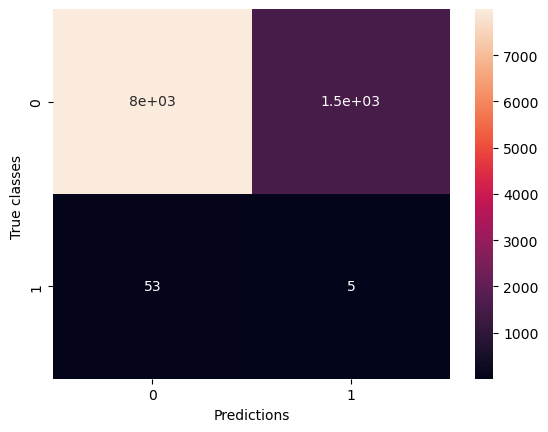

In [73]:
cross_validation(rnf,"f1",new_x_sm_train,y_sm_train,new_x_test,y_test)

score:  92.83729648627906
[[8029 1520]
 [  19    5]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      9549
           1       0.00      0.21      0.01        24

    accuracy                           0.84      9573
   macro avg       0.50      0.52      0.46      9573
weighted avg       1.00      0.84      0.91      9573



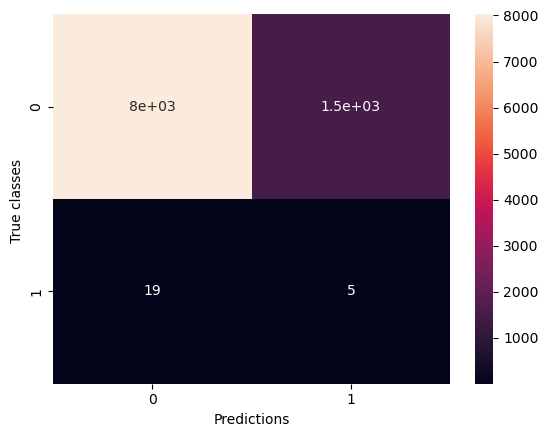

In [74]:
cross_validation(rnf,"roc_auc",new_x_sm_train,y_sm_train,new_x_test,y_test)

In [83]:
# Use Standard Scaler 

(14364, 25)

In [145]:
scaler=StandardScaler()

In [148]:
scaled_x=scaler.fit_transform(X)
scaled_x.shape

(31908, 25)

In [150]:
x_train,x_test,y_train,y_test=train_test_split(scaled_x,Y,test_size=0.3,random_state=15,stratify=Y)
print("x_train: ",x_train.shape,"y_train: ",y_train.shape,
      "x_test: ",x_test.shape,"y_test: ",y_test.shape)

x_train:  (22335, 25) y_train:  (22335,) x_test:  (9573, 25) y_test:  (9573,)


In [164]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy="minority")
smote
x_sm,y_sm=smote.fit_resample(x_train,y_train)
y_sm
x_sm.shape

sm_df=pd.concat([pd.DataFrame(x_sm),pd.DataFrame(y_sm)],axis=1)
sm_df.drop_duplicates(inplace=True)

In [166]:
x_sm_train=sm_df.drop(columns=["booking_complete"])
y_sm_train=sm_df["booking_complete"]

score:  77.53669828546553
[[5192  854]
 [2856  671]]
              precision    recall  f1-score   support

           0       0.65      0.86      0.74      6046
           1       0.44      0.19      0.27      3527

    accuracy                           0.61      9573
   macro avg       0.54      0.52      0.50      9573
weighted avg       0.57      0.61      0.56      9573



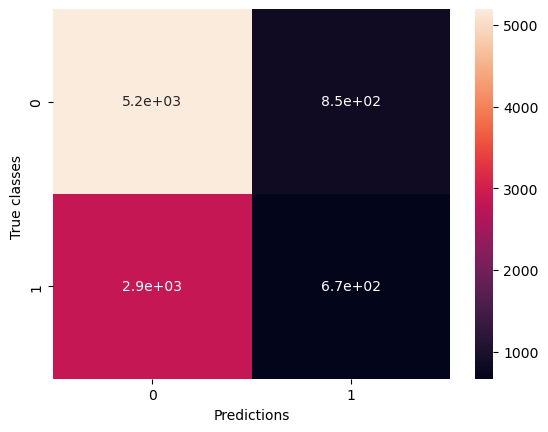

In [167]:
cross_validation(rnf,"accuracy",x_sm_train,y_sm_train,x_test,y_test)

score:  83.51293843891973
[[5030  834]
 [3018  691]]
              precision    recall  f1-score   support

           0       0.62      0.86      0.72      5864
           1       0.45      0.19      0.26      3709

    accuracy                           0.60      9573
   macro avg       0.54      0.52      0.49      9573
weighted avg       0.56      0.60      0.55      9573



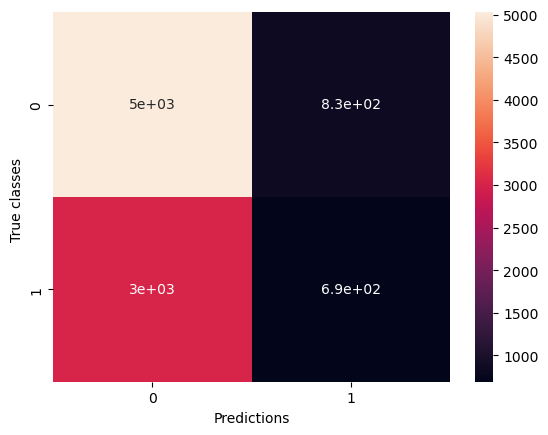

In [168]:
cross_validation(rnf,f2_scorer,x_sm_train,y_sm_train,x_test,y_test)

score:  73.93778298802366
[[4956  819]
 [3092  706]]
              precision    recall  f1-score   support

           0       0.62      0.86      0.72      5775
           1       0.46      0.19      0.27      3798

    accuracy                           0.59      9573
   macro avg       0.54      0.52      0.49      9573
weighted avg       0.56      0.59      0.54      9573



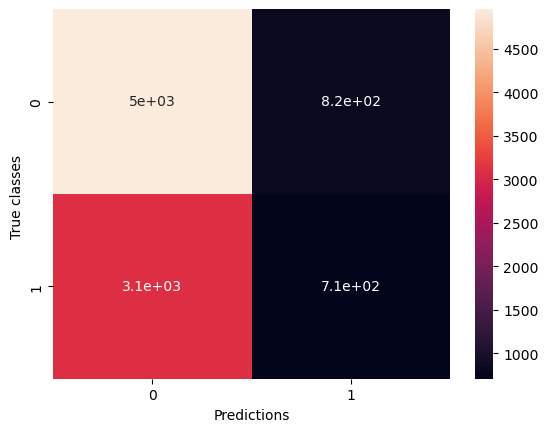

In [169]:
cross_validation(rnf,g_mean_scorer,x_sm_train,y_sm_train,x_test,y_test)

score:  83.07623360407023
[[5065  854]
 [2983  671]]
              precision    recall  f1-score   support

           0       0.63      0.86      0.73      5919
           1       0.44      0.18      0.26      3654

    accuracy                           0.60      9573
   macro avg       0.53      0.52      0.49      9573
weighted avg       0.56      0.60      0.55      9573



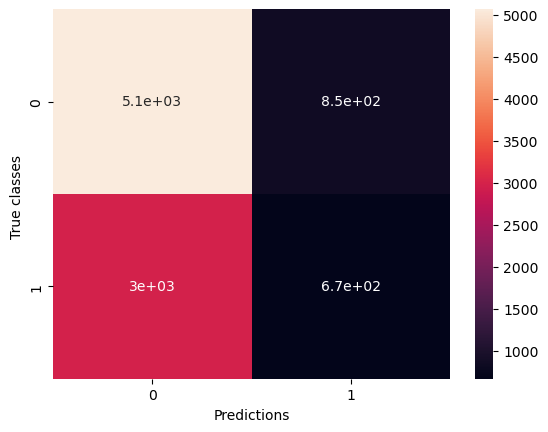

In [170]:
cross_validation(rnf,"f1",x_sm_train,y_sm_train,x_test,y_test)

score:  84.57870943469969
[[5124  871]
 [2924  654]]
              precision    recall  f1-score   support

           0       0.64      0.85      0.73      5995
           1       0.43      0.18      0.26      3578

    accuracy                           0.60      9573
   macro avg       0.53      0.52      0.49      9573
weighted avg       0.56      0.60      0.55      9573



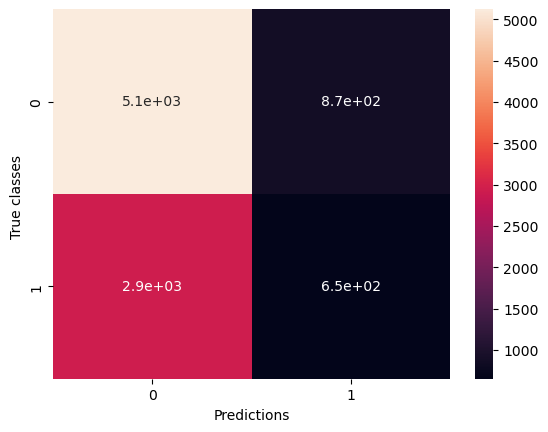

In [171]:
cross_validation(rnf,"roc_auc",x_sm_train,y_sm_train,x_test,y_test)

### we can release that the best score are obtained by training our model with all the features  

In [184]:
#y_sm_train,x_test,y_test

,Unnamed: 0,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,...,booking_origin_Timor-Leste,booking_origin_Tonga,booking_origin_Tunisia,booking_origin_Turkey,booking_origin_Ukraine,booking_origin_United Arab Emirates,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vanuatu,booking_origin_Vietnam
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37550,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
37551,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
37552,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
37553,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


score:  80.23677879318974
[[6630  977]
 [1418  548]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      7607
           1       0.36      0.28      0.31      1966

    accuracy                           0.75      9573
   macro avg       0.59      0.58      0.58      9573
weighted avg       0.73      0.75      0.74      9573



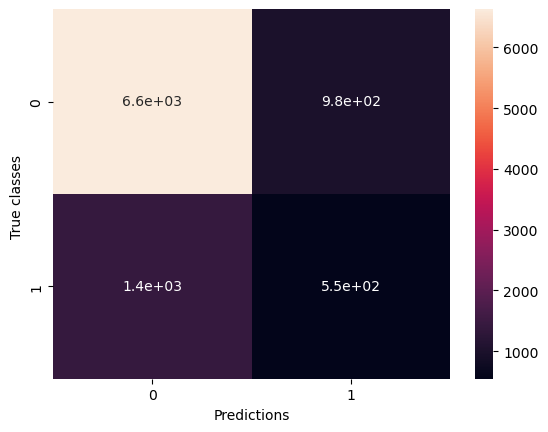

In [206]:
cross_validation(rnf,"accuracy",x_sm_train,y_sm_train,x_test,y_test)

## hyper tunning model

In [ ]:
params={"n_estimators":[80,100,200,300,500],
    "max_depth":[1,2,3,4],
    "min_samples_split":[2,5,7],
    "min_samples_leaf":[1,2,4,5],

    "max_features":['auto','sqrt'],

    "bootstrap":[False,True]
       }


rnf=RandomForestClassifier()
gs_rnf=GridSearchCV(rnf,param_grid=params,scoring="accuracy",cv=5,n_jobs=-1)
gs_rnf.fit(x_sm_train,y_sm_train)

In [ ]:
def evaluate(model,x_test, y_test):
    predictions = model.predict(x_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    matrix=confusion_matrix(predictions,y_test)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print("clasification report: ",classification_report(predictions,y_test))
    
    sns.heatmap(matrix,annot=True)
    plt.ylabel("Predictions")
    plt.xlabel("True classes ")


In [ ]:
evaluate(gs_rnf.best_estimator_,x_test, y_test)